In [1]:
import os
import string
import torch
import numpy as np
import scipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import dill
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
import torch.distributions as dist
from matplotlib.backends.backend_pdf import PdfPages

from cognitive_modeling.models.utility_models import u_pow, u_lin
from cognitive_modeling.cpc_like import fit_cpc_like
from discrepancy_modeling.discrepancy_modeling import DiscrepancyModel
from data.data import get
from accuracy_comparison.accuracy_comparison import accuracy_comparison_cpc

In [2]:
%config InlineBackend.figure_format = "retina"
sns.set_context("paper")

In [3]:
bf = "bkp/dm_cpc_new_mean_correction=2_lr=05_epochs=300.pkl"

In [4]:
np.random.seed(123)
torch.manual_seed(123);

In [5]:
# Loading
df_dm = pd.read_pickle(bf)
df_dm.dm = df_dm.dm.apply(lambda x: dill.loads(x))
df_dm

,subject,dm,h,u,tau,theta,epochs,learning_rate,seed_cog_fit,seed_dm_train,git_branch,git_hash,n_samples,inducing_points,learn_inducing_locations,mean_correction,jitter
0,10100,<discrepancy_modeling.discrepancy_modeling.Dis...,sigmoid,u_pow,1292.693187,0.981149,300,0.05,12345,12345,main,366fa1bc5b9fa31ac7fd6d0ab6413c6a90f8ccce,100,"[0.0196078431372549, 0.0392156862745098, 0.058...",False,2,1.000000e-07
1,11020,<discrepancy_modeling.discrepancy_modeling.Dis...,sigmoid,u_pow,16670.197828,1.003339,300,0.05,12345,12345,main,366fa1bc5b9fa31ac7fd6d0ab6413c6a90f8ccce,100,"[0.0196078431372549, 0.0392156862745098, 0.058...",False,2,1.000000e-07
2,11303,<discrepancy_modeling.discrepancy_modeling.Dis...,sigmoid,u_pow,669.895791,1.151018,300,0.05,12345,12345,main,366fa1bc5b9fa31ac7fd6d0ab6413c6a90f8ccce,100,"[0.0196078431372549, 0.0392156862745098, 0.058...",False,2,1.000000e-07
3,11302,<discrepancy_modeling.discrepancy_modeling.Dis...,sigmoid,u_pow,8.902199,0.382136,300,0.05,12345,12345,main,366fa1bc5b9fa31ac7fd6d0ab6413c6a90f8ccce,100,"[0.0196078431372549, 0.0392156862745098, 0.058...",False,2,1.000000e-07
4,11301,<discrepancy_modeling.discrepancy_modeling.Dis...,sigmoid,u_pow,14.834300,0.537319,300,0.05,12345,12345,main,366fa1bc5b9fa31ac7fd6d0ab6413c6a90f8ccce,100,"[0.0196078431372549, 0.0392156862745098, 0.058...",False,2,1.000000e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,10325,<discrepancy_modeling.discrepancy_modeling.Dis...,sigmoid,u_pow,12.753401,1.161890,300,0.05,12345,12345,main,366fa1bc5b9fa31ac7fd6d0ab6413c6a90f8ccce,100,"[0.0196078431372549, 0.0392156862745098, 0.058...",False,2,1.000000e-07
121,10330,<discrepancy_modeling.discrepancy_modeling.Dis...,sigmoid,u_pow,79.059404,1.096486,300,0.05,12345,12345,main,366fa1bc5b9fa31ac7fd6d0ab6413c6a90f8ccce,100,"[0.0196078431372549, 0.0392156862745098, 0.058...",False,2,1.000000e-07
122,10331,<discrepancy_modeling.discrepancy_modeling.Dis...,sigmoid,u_pow,127.554246,0.824917,300,0.05,12345,12345,main,366fa1bc5b9fa31ac7fd6d0ab6413c6a90f8ccce,100,"[0.0196078431372549, 0.0392156862745098, 0.058...",False,2,1.000000e-07
123,10340,<discrepancy_modeling.discrepancy_modeling.Dis...,sigmoid,u_pow,12.519762,0.306420,300,0.05,12345,12345,main,366fa1bc5b9fa31ac7fd6d0ab6413c6a90f8ccce,100,"[0.0196078431372549, 0.0392156862745098, 0.058...",False,2,1.000000e-07


In [6]:
for s in tqdm(df_dm.index):
    
    test_x = torch.linspace(0.01, 0.99, 1000)
    
    dm = df_dm.loc[s, "dm"]
    
    m_pred, f_pred = dm.pred(test_x, n_samples=1000) 
    
    m_pred = m_pred.numpy()
    f_pred = f_pred.numpy()

    f_mean = f_pred.mean(axis=0)
    lower, upper = np.percentile(f_pred, [2.5, 97.5], axis=0)
    
    d_mean_x = f_mean - m_pred 
    d_unc_x = upper - lower
    
    df_dm.loc[s, "d_mean"] = np.abs(d_mean_x).mean()
    df_dm.loc[s, "d_unc"] = d_unc_x.mean()

  0%|          | 0/125 [00:00<?, ?it/s]

/Users/aureliennioche/.pyenv/versions/3.9.1/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/Users/aureliennioche/.pyenv/versions/3.9.1/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/Users/aureliennioche/.pyenv/versions/3.9.1/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/Users/aureliennioche/.pyenv/versions/3.9.1/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.

In [7]:
d_mean = df_dm.d_mean.values
d_unc = df_dm.d_unc.values

In [36]:
theta = df_dm.d_unc.values

In [8]:
print(f"Discrepancy (mean): min={d_mean.min()}, max={d_mean.max()}")
print(f"Discrepancy (uncertainty): min={d_unc.min()}, max={d_unc.max()}")

Discrepancy (mean): min=1.1018276381946635e-05, max=0.201207235455513
Discrepancy (uncertainty): min=0.0012768437221646345, max=0.8732477737781592


In [10]:
scipy.stats.spearmanr(d_mean, d_unc)

SpearmanrResult(correlation=0.8504823348694315, pvalue=4.043277305207191e-36)

In [54]:
idx_uncertain = d_unc.argmax()
dm_uncertain = df_dm.iloc[d_unc.argmax()].dm
val_uncertain = d_unc[idx_uncertain]

In [55]:
df_dm.iloc[idx_uncertain].d_unc

0.8732477737781592

In [56]:
bound_unc = np.percentile(d_unc, [95, ], axis=0)[0]
print(f"Bound uncertainty {bound_unc}")
bounds_theta = np.percentile(theta, [2.5, 97.5], axis=0)
print(f"Bounds theta {bounds_theta}")

Bound uncertainty 0.5080148722563451
Bounds theta [0.00832237 0.72284432]


In [63]:
# low, medium and high discrepancy, select individuals with not extreme disc. SD
df_select = df_dm[(d_unc <= bound_unc) 
                  & (theta >= bound_theta[0]) 
                  & (theta <= bound_theta[1])
                 ] # & (df_dm.disc_mean < bound_mean), ]
d_mean_slc = df_select.d_mean.values 

idx_low = d_mean_slc.argmin()
dm_low = df_select.iloc[idx_low].dm
val_low = d_mean_slc[idx_low]

idx_high = d_mean_slc.argmax()
dm_high = df_select.iloc[idx_high].dm
val_high = d_mean_slc[idx_high]

dist_to_middle_ground = np.abs(d_mean_slc - 0.5*(d_mean_slc.max() - d_mean_slc.min()))
dist_to_middle_ground[idx_high] = np.inf
dist_to_middle_ground[idx_low] = np.inf
idx_medium = np.argmin(dist_to_middle_ground)
dm_medium = df_select.iloc[idx_medium].dm
val_medium = d_mean_slc[idx_medium]

In [65]:
print(f"Low: subject {df_select.iloc[idx_low].subject}; δ={val_low:.3f}")
print(f"Medium: subject {df_select.iloc[idx_medium].subject}; δ={val_medium:.3f}")
print(f"High: subject {df_select.iloc[idx_high].subject}; δ={val_high:.3f}")
print(f"Uncertain: subject {df_dm.iloc[idx_uncertain].subject}; u_δ={val_uncertain:.3f}")

Low: subject 11315; δ=0.000
Medium: subject 11005; δ=0.089
High: subject 11016; δ=0.184
Uncertain: subject 11319; u_δ=0.873


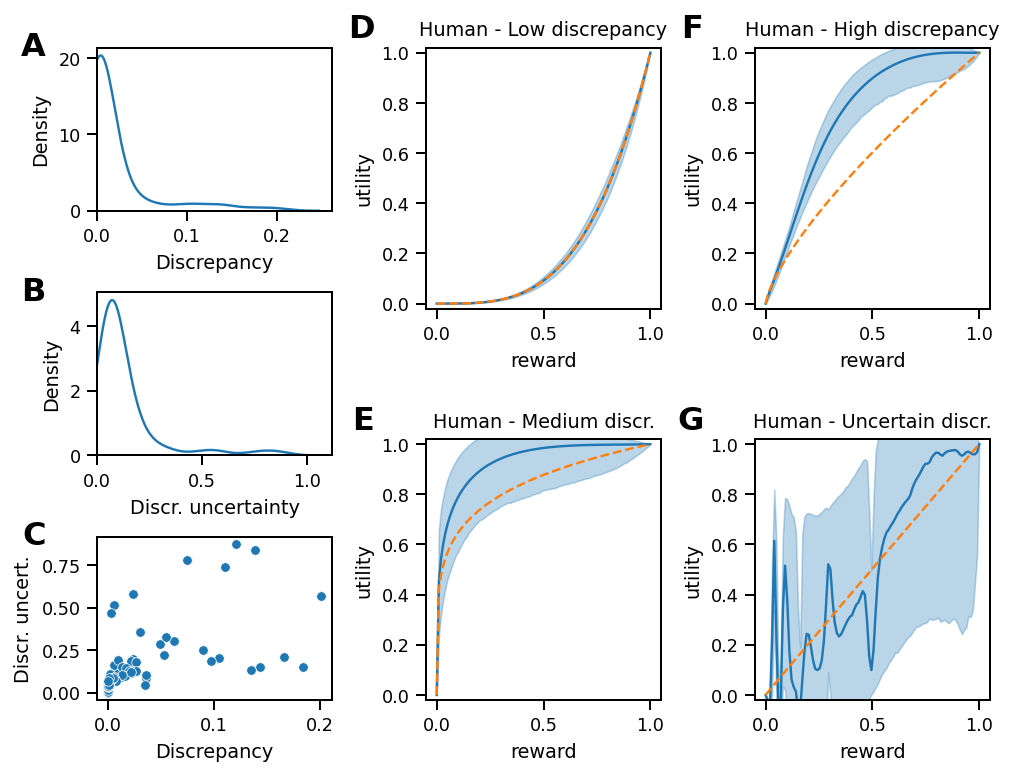

In [51]:
letters = (letter for letter in string.ascii_uppercase)

# for left column only
letter_placement_left = -0.22, 1.1
letter_placement_right = -0.22, 1.13

fig = plt.figure(figsize=(8, 6))
gs = fig.add_gridspec(1, 3)

gs_left = gs[0].subgridspec(3, 1)
gs_right = gs[1:].subgridspec(2, 2)

ax = fig.add_subplot(gs_left[0])

sns.kdeplot(d_mean, ax=ax)
ax.set_xlim(0, None);
ax.set_xlabel("Discrepancy")

ax.text(*letter_placement_left, s=next(letters), transform=ax.transAxes, fontsize=16, 
        fontweight='bold', va='top', ha='right')

ax = fig.add_subplot(gs_left[1])

sns.kdeplot(d_unc, ax=ax)
ax.set_xlim(0, None);
ax.set_xlabel("Discr. uncertainty")

ax.text(*letter_placement_left, s=next(letters), transform=ax.transAxes, fontsize=16, 
        fontweight='bold', va='top', ha='right')

ax = fig.add_subplot(gs_left[2])

sns.scatterplot(x=d_mean, y=d_unc, ax=ax)
ax.set_xlabel("Discrepancy")
ax.set_ylabel("Discr. uncert.")

ax.text(*letter_placement_left, s=next(letters), transform=ax.transAxes, fontsize=16, 
        fontweight='bold', va='top', ha='right')

all_axes = [fig.add_subplot(gs_right[i, j]) for j in range(2) for i in range(2)]

axes = (ax for ax in all_axes)

for dm, dm_name in ((dm_low, "Human - Low discrepancy"), 
                    (dm_medium, "Human - Medium discr."), 
                    (dm_high, "Human - High discrepancy"), 
                    (dm_uncertain, "Human - Uncertain discr.")):
    
    ax = next(axes)
    ax.set_title(dm_name)

    fill_alpha = 0.3

    test_x = torch.linspace(0, 1, 100)
    m_pred, f_pred = dm.pred(test_x)

    test_x = test_x.numpy()
    m_pred = m_pred.numpy()
    f_pred = f_pred.numpy()

    f_mean = f_pred.mean(axis=0)
    lower, upper = np.percentile(f_pred, [2.5, 97.5], axis=0)
    
    letter = next(letters)    
    ax.text(*letter_placement_right, s=letter, transform=ax.transAxes, fontsize=16, 
            fontweight='bold', va='top', ha='right')

    # GP confidence
    h_conf = ax.fill_between(test_x, upper, lower, color='C0', alpha=fill_alpha, label="Model + correction - Confidence")

    # GP mean
    h_mean, = ax.plot(test_x, f_mean, label="Model + correction - Mean")

    # Model
    h_model, = ax.plot(test_x, m_pred, color='C1', ls="--", label="Model alone")
    
    ax.set_ylim(-0.02, 1.02)
    ax.set_xlabel("reward")
    ax.set_ylabel("utility")


# plt.tight_layout()
plt.subplots_adjust(hspace=0.5, wspace=0.4)

os.makedirs("fig", exist_ok=True)
plt.savefig("fig/risk_cpc.pdf", bbox_inches='tight')

In [52]:
roc_m_all, roc_dm_all = accuracy_comparison_cpc(dataframe=df_dm, verbose=False)

/Users/aureliennioche/.pyenv/versions/3.9.1/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/Users/aureliennioche/.pyenv/versions/3.9.1/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/Users/aureliennioche/.pyenv/versions/3.9.1/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/Users/aureliennioche/.pyenv/versions/3.9.1/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.

Only one class present in y_true. ROC AUC score is not defined in that case.
Only one class present in y_true. ROC AUC score is not defined in that case.


ValueError: too many values to unpack (expected 2)

In [8]:
improvement = roc_dm_all - roc_m_all
print("absolute improvement", np.nanmean(improvement), np.nanstd(improvement))

absolute improvement 0.017241950885669377 0.06425088757160162


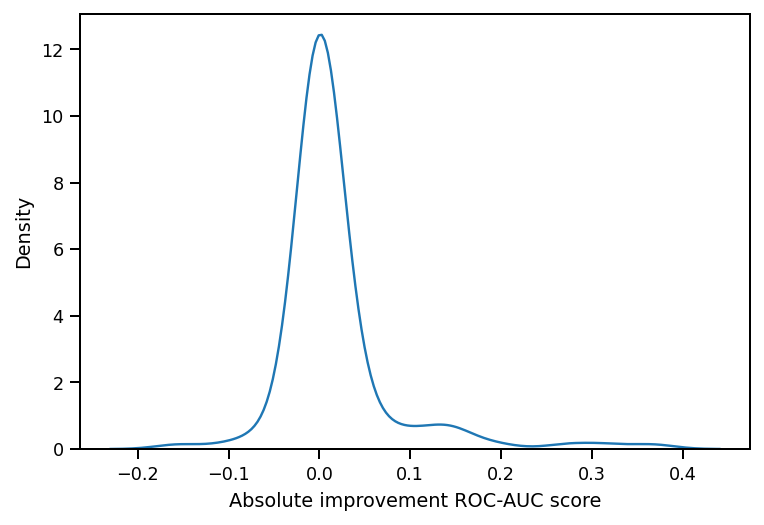

In [9]:
fig, ax = plt.subplots()
sns.kdeplot(improvement, ax=ax)
ax.set_xlabel("Absolute improvement ROC-AUC score");

In [10]:
improvement = (roc_dm_all - roc_m_all) / roc_m_all
print("relative improvement", np.nanmean(improvement), np.nanstd(improvement))

relative improvement 0.050943471562256655 0.1872329600703893


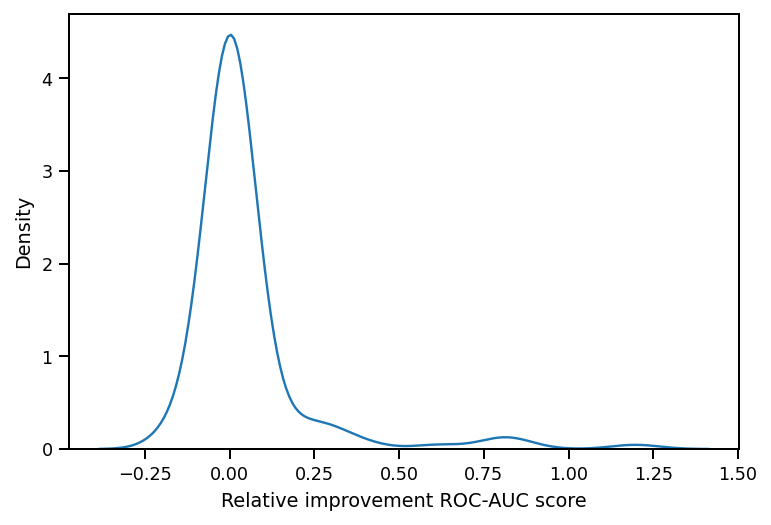

In [24]:
fig, ax = plt.subplots()
sns.kdeplot(improvement, ax=ax)
ax.set_xlabel("Relative improvement ROC-AUC score");

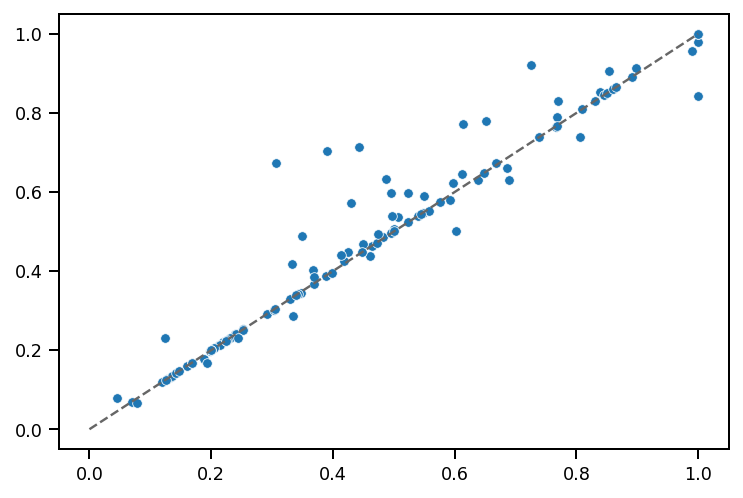

In [12]:
fig, ax = plt.subplots()
ax.plot((0, 1), (0, 1), ls="--", color="0.4");
sns.scatterplot(x=roc_m_all, y=roc_dm_all, ax=ax)
plt.show()

In [ ]:
import os
import string
import torch
import numpy as np
import scipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import dill
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
import torch.distributions as dist
from matplotlib.backends.backend_pdf import PdfPages

from cognitive_modeling.models.utility_models import u_pow, u_lin
from cognitive_modeling.cpc_like import fit_cpc_like
from discrepancy_modeling.discrepancy_modeling import DiscrepancyModel
from data.data import get
from accuracy_comparison.accuracy_comparison import accuracy_comparison_cpc

%config InlineBackend.figure_format = "retina"
sns.set_context("paper")

bf = "bkp/dm_cpc_new_mean_correction=2_lr=05_epochs=300.pkl"

np.random.seed(123)
torch.manual_seed(123);

# Loading
df_dm = pd.read_pickle(bf)
df_dm.dm = df_dm.dm.apply(lambda x: dill.loads(x))
df_dm

for s in tqdm(df_dm.index):
    
    test_x = torch.linspace(0.01, 0.99, 1000)
    
    dm = df_dm.loc[s, "dm"]
    
    m_pred, f_pred = dm.pred(test_x, n_samples=1000) 
    
    m_pred = m_pred.numpy()
    f_pred = f_pred.numpy()

    f_mean = f_pred.mean(axis=0)
    lower, upper = np.percentile(f_pred, [2.5, 97.5], axis=0)
    
    d_mean_x = f_mean - m_pred 
    d_unc_x = upper - lower
    
    df_dm.loc[s, "d_mean"] = np.abs(d_mean_x).mean()
    df_dm.loc[s, "d_unc"] = d_unc_x.mean()

d_mean = df_dm.d_mean.values
d_unc = df_dm.d_unc.values

theta = df_dm.d_unc.values

print(f"Discrepancy (mean): min={d_mean.min()}, max={d_mean.max()}")
print(f"Discrepancy (uncertainty): min={d_unc.min()}, max={d_unc.max()}")

scipy.stats.spearmanr(d_mean, d_unc)

idx_uncertain = d_unc.argmax()
dm_uncertain = df_dm.iloc[d_unc.argmax()].dm
val_uncertain = d_unc[idx_uncertain]

df_dm.iloc[idx_uncertain].d_unc

bound_unc = np.percentile(d_unc, [95, ], axis=0)[0]
print(f"Bound uncertainty {bound_unc}")
bounds_theta = np.percentile(theta, [2.5, 97.5], axis=0)
print(f"Bounds theta {bounds_theta}")

# low, medium and high discrepancy, select individuals with not extreme disc. SD
df_select = df_dm[(d_unc <= bound_unc) 
                  & (theta >= bound_theta[0]) 
                  & (theta <= bound_theta[1])
                 ] # & (df_dm.disc_mean < bound_mean), ]
d_mean_slc = df_select.d_mean.values 

idx_low = d_mean_slc.argmin()
dm_low = df_select.iloc[idx_low].dm
val_low = d_mean_slc[idx_low]

idx_high = d_mean_slc.argmax()
dm_high = df_select.iloc[idx_high].dm
val_high = d_mean_slc[idx_high]

dist_to_middle_ground = np.abs(d_mean_slc - 0.5*(d_mean_slc.max() - d_mean_slc.min()))
dist_to_middle_ground[idx_high] = np.inf
dist_to_middle_ground[idx_low] = np.inf
idx_medium = np.argmin(dist_to_middle_ground)
dm_medium = df_select.iloc[idx_medium].dm
val_medium = d_mean_slc[idx_medium]

print(f"Low: subject {df_select.iloc[idx_low].subject}; δ={val_low:.3f}")
print(f"Medium: subject {df_select.iloc[idx_medium].subject}; δ={val_medium:.3f}")
print(f"High: subject {df_select.iloc[idx_high].subject}; δ={val_high:.3f}")
print(f"Uncertain: subject {df_dm.iloc[idx_uncertain].subject}; u_δ={val_uncertain:.3f}")

letters = (letter for letter in string.ascii_uppercase)

# for left column only
letter_placement_left = -0.22, 1.1
letter_placement_right = -0.22, 1.13

fig = plt.figure(figsize=(8, 6))
gs = fig.add_gridspec(1, 3)

gs_left = gs[0].subgridspec(3, 1)
gs_right = gs[1:].subgridspec(2, 2)

ax = fig.add_subplot(gs_left[0])

sns.kdeplot(d_mean, ax=ax)
ax.set_xlim(0, None);
ax.set_xlabel("Discrepancy")

ax.text(*letter_placement_left, s=next(letters), transform=ax.transAxes, fontsize=16, 
        fontweight='bold', va='top', ha='right')

ax = fig.add_subplot(gs_left[1])

sns.kdeplot(d_unc, ax=ax)
ax.set_xlim(0, None);
ax.set_xlabel("Discr. uncertainty")

ax.text(*letter_placement_left, s=next(letters), transform=ax.transAxes, fontsize=16, 
        fontweight='bold', va='top', ha='right')

ax = fig.add_subplot(gs_left[2])

sns.scatterplot(x=d_mean, y=d_unc, ax=ax)
ax.set_xlabel("Discrepancy")
ax.set_ylabel("Discr. uncert.")

ax.text(*letter_placement_left, s=next(letters), transform=ax.transAxes, fontsize=16, 
        fontweight='bold', va='top', ha='right')

all_axes = [fig.add_subplot(gs_right[i, j]) for j in range(2) for i in range(2)]

axes = (ax for ax in all_axes)

for dm, dm_name in ((dm_low, "Human - Low discrepancy"), 
                    (dm_medium, "Human - Medium discr."), 
                    (dm_high, "Human - High discrepancy"), 
                    (dm_uncertain, "Human - Uncertain discr.")):
    
    ax = next(axes)
    ax.set_title(dm_name)

    fill_alpha = 0.3

    test_x = torch.linspace(0, 1, 100)
    m_pred, f_pred = dm.pred(test_x)

    test_x = test_x.numpy()
    m_pred = m_pred.numpy()
    f_pred = f_pred.numpy()

    f_mean = f_pred.mean(axis=0)
    lower, upper = np.percentile(f_pred, [2.5, 97.5], axis=0)
    
    letter = next(letters)    
    ax.text(*letter_placement_right, s=letter, transform=ax.transAxes, fontsize=16, 
            fontweight='bold', va='top', ha='right')

    # GP confidence
    h_conf = ax.fill_between(test_x, upper, lower, color='C0', alpha=fill_alpha, label="Model + correction - Confidence")

    # GP mean
    h_mean, = ax.plot(test_x, f_mean, label="Model + correction - Mean")

    # Model
    h_model, = ax.plot(test_x, m_pred, color='C1', ls="--", label="Model alone")
    
    ax.set_ylim(-0.02, 1.02)
    ax.set_xlabel("reward")
    ax.set_ylabel("utility")


# plt.tight_layout()
plt.subplots_adjust(hspace=0.5, wspace=0.4)

os.makedirs("fig", exist_ok=True)
plt.savefig("fig/risk_cpc.pdf", bbox_inches='tight')

roc_m_all, roc_dm_all = accuracy_comparison_cpc(dataframe=df_dm, verbose=False)

improvement = roc_dm_all - roc_m_all
print("absolute improvement", np.nanmean(improvement), np.nanstd(improvement))

fig, ax = plt.subplots()
sns.kdeplot(improvement, ax=ax)
ax.set_xlabel("Absolute improvement ROC-AUC score");

improvement = (roc_dm_all - roc_m_all) / roc_m_all
print("relative improvement", np.nanmean(improvement), np.nanstd(improvement))

fig, ax = plt.subplots()
sns.kdeplot(improvement, ax=ax)
ax.set_xlabel("Relative improvement ROC-AUC score");

fig, ax = plt.subplots()
ax.plot((0, 1), (0, 1), ls="--", color="0.4");
sns.scatterplot(x=roc_m_all, y=roc_dm_all, ax=ax)
plt.show()